Installing Required Libraries

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=434a20020dc8473722afde6dc4130d8e53ec6f7321b2b89696745eccec953d41
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
import nltk
from rouge_score import rouge_scorer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Loading the dataset
df = pd.read_parquet("preprocessed_data.parquet")

In [ ]:
# Loading the model
model = tf.keras.models.load_model('text_summarization_model.h5', custom_objects={'_TextVectorization': TextVectorization})

In [ ]:
# Load tokenizers
with open('tokenizer_articles.pkl', 'rb') as f:
    tokenizer_articles = pickle.load(f)

with open('tokenizer_abstracts.pkl', 'rb') as f:
    tokenizer_abstracts = pickle.load(f)

# Define or load your index_to_word dictionary
with open('index_to_word.pkl', 'rb') as f:
    index_to_word = pickle.load(f)

Predictions

In [ ]:
# Define padding token if applicable
padding_token = 0  # Adjust based on your model's padding token index

# Function to decode the predicted summary
def decode_sequence(predicted_summary, index_to_word, padding_token=0):
    # Get the index of the maximum probability for each token position
    token_indices = np.argmax(predicted_summary, axis=-1)

    # Convert token indices to words, excluding padding tokens
    decoded_summary = ' '.join([index_to_word.get(idx, '') for idx in token_indices[0] if idx != padding_token])

    return decoded_summary

# Define max lengths
max_len_articles = 400  # Set the max length based on your model
max_len_abstracts = 100  # Set the max length based on your model

# Iterate over each row in the DataFrame to process the data
for index, row in df.head(10).iterrows():
    article = row['article']
    abstract = row['abstract']

    # Tokenize text
    tokenized_article = tokenizer_articles.texts_to_sequences([article])
    tokenized_article = pad_sequences(tokenized_article, maxlen=max_len_articles, padding='post')

    tokenized_abstract = tokenizer_abstracts.texts_to_sequences([abstract])
    tokenized_abstract = pad_sequences(tokenized_abstract, maxlen=max_len_abstracts, padding='post')

    # Predict the summary
    predicted_summary = model.predict([tokenized_article, tokenized_abstract])

    # Decode the predicted summary
    decoded_summary = decode_sequence(predicted_summary, index_to_word, padding_token)

    # Print or store the results
    print(f"Original Article: {article}")
    print(f"Generated Summary: {decoded_summary}")
    print("-" * 50)

# Optionally, you can store the decoded summaries back into the DataFrame or another structure
df['predicted_summary'] = df.apply(lambda row: decode_sequence(model.predict([pad_sequences(tokenizer_articles.texts_to_sequences([row['article']]), maxlen=max_len_articles, padding='post'),
                                                                              pad_sequences(tokenizer_abstracts.texts_to_sequences([row['abstract']]), maxlen=max_len_abstracts, padding='post')]),
                                                                 index_to_word, padding_token), axis=1)

# Save the updated DataFrame with predicted summaries
df.to_csv("predicted_summaries.csv", index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 104ms/step


In [ ]:
predict = pd.read_csv("predicted_summaries.csv")
predict

,article,abstract,predicted_summary
0,eligible participants one thousand eight hundr...,objectivetaspoglutide is long acting glucagon ...,small urms characteristics small of the of of ...
1,reactive oxygen species cytokines considered i...,pancreatic cancer is one of the most aggressiv...,small rickettsies gram of small small small...
2,sixty two year old female patient referred reg...,plasmacytoma is plasma cell neoplasm that loca...,island six case secondary strain strain strai...
3,major advantage small molecule cell based scre...,summarywe have carried out cell based screen a...,mostly the in of the may of may lead the of ...
4,elevation brain temperature common acute ische...,brain temperature is elevated in acute ischemi...,the main secondary of the successful small of...
...,...,...,...
9995,describe use targeted lc ms ms different softw...,the filamentous bacterium streptomyces coelico...,may of the small small report lymphangioma of ...
9996,autoantibodies hallmark diagnosis many systemi...,diagnostic tests are needed to aid in the diag...,the small cm small characteristics database ra...
9997,estimate two hundred forty million people chro...,background cirrhosis is common complication of...,available the secondary small small small smal...
9998,tenofovir disoproxil fumarate oral prodrug ten...,we report fifty five year old female who prese...,here resected souches souches content located...


In [ ]:
df = df.head(10)

In [ ]:
# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define padding token if applicable
padding_token = 0  # Adjust based on your model's padding token index

# Function to decode the predicted summary
def decode_sequence(predicted_summary, index_to_word, padding_token=0):
    # Get the index of the maximum probability for each token position
    token_indices = np.argmax(predicted_summary, axis=-1)

    # Convert token indices to words, excluding padding tokens
    decoded_summary = ' '.join([index_to_word.get(idx, '') for idx in token_indices[0] if idx != padding_token])

    return decoded_summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(predicted_summary, actual_summary):
    scores = scorer.score(actual_summary, predicted_summary)
    return scores

# Initialize lists to store ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Tokenize text
max_len_articles = 400  # Set the max length based on your model
max_len_abstracts = 100  # Set the max length based on your model

# Iterate over each row in the DataFrame to process the data and calculate ROUGE scores
for index, row in df.iterrows():
    article = row['article']
    abstract = row['abstract']

    # Tokenize and pad the text
    tokenized_article = tokenizer_articles.texts_to_sequences([article])
    tokenized_article = pad_sequences(tokenized_article, maxlen=max_len_articles, padding='post')

    tokenized_abstract = tokenizer_abstracts.texts_to_sequences([abstract])
    tokenized_abstract = pad_sequences(tokenized_abstract, maxlen=max_len_abstracts, padding='post')

    # Predict the summary
    predicted_summary = model.predict([tokenized_article, tokenized_abstract])
    decoded_summary = decode_sequence(predicted_summary, index_to_word, padding_token)

    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(decoded_summary, abstract)

    # Append the scores to respective lists
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # Print or store the results
    print(f"Original Article: {article}")
    print(f"Generated Summary: {decoded_summary}")
    print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure}")
    print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure}")
    print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure}")
    print("-" * 50)

# Optionally, you can add these scores back into your DataFrame
df['ROUGE-1'] = rouge1_scores
df['ROUGE-2'] = rouge2_scores
df['ROUGE-L'] = rougeL_scores

# Calculate the average ROUGE scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"Average ROUGE-1: {average_rouge1}")
print(f"Average ROUGE-2: {average_rouge2}")
print(f"Average ROUGE-L: {average_rougeL}")

# Save the updated DataFrame with ROUGE scores
df.to_csv("predicted_summaries_with_rouge.csv", index=False)

1/1 [==============================] - 1s 1s/step
Original Article: eligible participants one thousand eight hundred seventy five years age type two diabetes hba seven ten bmi twenty five kg forty five kg receiving stable dose antihyperglycemic medication three months prior screening key exclusion criteria advanced diabetes complications gastrointestinal disease previous bariatric surgery pancreatitis cardiovascular disease previous exposure glp one receptor agonists trial conducted accordance declaration helsinki national regulations protocol approved local independent ethics committees institutional review boards emerge two randomized open label active comparator parallel group phase three trial twenty four week core phase twenty eight week extension phase optional one hundred four week long term extension phase trial conducted one hundred eighty nine sites twenty three countries participants randomly assigned receive subcutaneous injections taspoglutide ten mg weekly taspoglutide te

1/1 [==============================] - 0s 109ms/step
Original Article: eligible participants one thousand eight hundred seventy five years age type two diabetes hba seven ten bmi twenty five kg forty five kg receiving stable dose antihyperglycemic medication three months prior screening key exclusion criteria advanced diabetes complications gastrointestinal disease previous bariatric surgery pancreatitis cardiovascular disease previous exposure glp one receptor agonists trial conducted accordance declaration helsinki national regulations protocol approved local independent ethics committees institutional review boards emerge two randomized open label active comparator parallel group phase three trial twenty four week core phase twenty eight week extension phase optional one hundred four week long term extension phase trial conducted one hundred eighty nine sites twenty three countries participants randomly assigned receive subcutaneous injections taspoglutide ten mg weekly taspoglutide

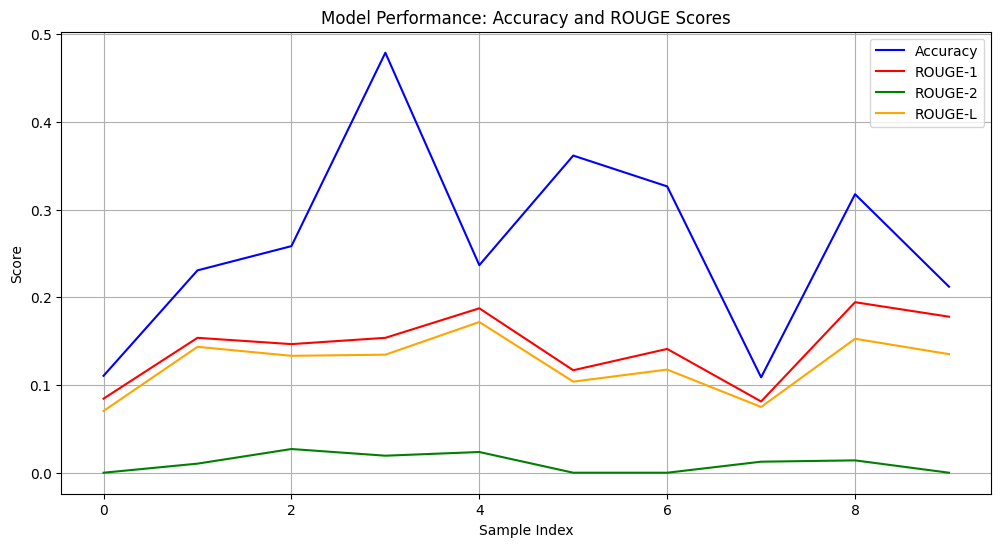

In [ ]:
# Function to calculate accuracy based on token matching
def calculate_accuracy(predicted_summary, actual_summary):
    predicted_tokens = predicted_summary.split()
    actual_tokens = actual_summary.split()

    # Calculate the number of matching tokens
    matching_tokens = sum(1 for token in predicted_tokens if token in actual_tokens)

    # Calculate accuracy as the ratio of matching tokens to the total number of tokens in the actual summary
    accuracy = matching_tokens / len(actual_tokens) if len(actual_tokens) > 0 else 0
    return accuracy

# Initialize list to store accuracy scores
accuracy_scores = []

# Iterate over each row in the DataFrame to calculate accuracy
for index, row in df.iterrows():
    article = row['article']
    abstract = row['abstract']

    # Tokenize and pad the text
    tokenized_article = tokenizer_articles.texts_to_sequences([article])
    tokenized_article = pad_sequences(tokenized_article, maxlen=max_len_articles, padding='post')

    tokenized_abstract = tokenizer_abstracts.texts_to_sequences([abstract])
    tokenized_abstract = pad_sequences(tokenized_abstract, maxlen=max_len_abstracts, padding='post')

    # Predict the summary
    predicted_summary = model.predict([tokenized_article, tokenized_abstract])
    decoded_summary = decode_sequence(predicted_summary, index_to_word, padding_token)

    # Calculate accuracy
    accuracy = calculate_accuracy(decoded_summary, abstract)

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

    # Print or store the results
    print(f"Original Article: {article}")
    print(f"Generated Summary: {decoded_summary}")
    print(f"Accuracy: {accuracy}")
    print("-" * 50)

# Optionally, you can add these scores back into your DataFrame
df['Accuracy'] = accuracy_scores

# Calculate the average accuracy
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {average_accuracy}")

# Save the updated DataFrame with accuracy scores
df.to_csv("predicted_summaries_with_rouge_and_accuracy.csv", index=False)

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy_scores, label='Accuracy', color='blue')
plt.plot(rouge1_scores, label='ROUGE-1', color='red')
plt.plot(rouge2_scores, label='ROUGE-2', color='green')
plt.plot(rougeL_scores, label='ROUGE-L', color='orange')

plt.title('Model Performance: Accuracy and ROUGE Scores')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()